# Demo Prophet Time Series Forecasting on Ray local

### Description:  
This notebook goes along with the tutorial <a href="https://towardsdatascience.com/scaling-time-series-forecasting-with-ray-arima-and-prophet-e6c856e605ee">How to Train Faster Time Series Forecasting Using Ray, part 1 of 2<a>.

This notebook demonstrates Time Series Forecasting Prophet algorithm on Ray.  Example data is NYC yellow taxi from: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page  <br>

Forecast goal:  Given 6 months historical taxi trips data for NYC, your task is to predict #pickups at each location in NYC at monthly level for the next 2 months.

### Demo notes:
Output shows timings using SMALL dataset <br>
Both demo datasets are available in this github repo under data/  <br>
SMALL dataset contains original, actual 260 items "clean_taxi_monthly.parquet" <br>
MEDIUM dataset contains 2860 items with extra fakes "clean_taxi_monthly_fake_medium.parquet" <br>

In [1]:
!python --version
import time, os, logging
from typing import Tuple
from dateutil.relativedelta import relativedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
num_cpu = os.cpu_count()

print(f"Number of CPUs in this system: {num_cpu}")
# Import forecasting libraries.
import prophet
from prophet import Prophet

print(f"prophet: {prophet.__version__}")

Python 3.8.13
Number of CPUs in this system: 8
prophet: 1.0


In [2]:
import ray

if ray.is_initialized():
    ray.shutdown()
ray.init()

2023-01-08 16:11:52,270	INFO worker.py:1519 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.13
Ray version:,2.1.0
Dashboard:,http://127.0.0.1:8265


In [3]:
print(ray.cluster_resources())

{'object_store_memory': 2147483648.0, 'memory': 9014478439.0, 'CPU': 8.0, 'node:127.0.0.1': 1.0}


# Read 8 months clean NYC taxi data 

New York City Yellow Taxi ride volumes per location (8 months of historical data). <ul>
    <li>Original source: https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page</li>
    <li>Clean monthly source:  https://github.com/christy/AnyscaleDemos/blob/main/forecasting_demos/data/clean_taxi_monthly.parquet?raw=true </li>
    </ul>

Normally there is a data cleaning/prep step to convert raw data -> cleaned data.  We'll dig into details of ETL later.  <br>
For now, let's just start with cleaned, aggregated monthly data for ARIMA and Prophet, since those algorithms are typically for strategic-level forecasting, not typically for detailed-level forecasting.

In [4]:
##########
## STEP 1.  Read data and ray.put() data into Ray shared cluster memory.
##########
# Read data into a Pandas dataframe.
filename = "../../../forecasting_demos/Ray_v1/data/clean_taxi_monthly.parquet"
g_month = pd.read_parquet(filename)

# Prophet requires timstamp is 'ds' and target_value name is 'y'
# Prophet requires at least 2 data points per timestamp
# StatsForecast requires location name is 'unique_id'

g_month.reset_index(inplace=True)
g_month.rename(columns={"pickup_monthly": "ds"}, inplace=True)
g_month.rename(columns={"pulocationid": "unique_id"}, inplace=True)
g_month.rename(columns={"trip_quantity": "y"}, inplace=True)
g_month.drop(['pickup_lat', 'pickup_lon'], axis=1, inplace=True)

# Put data in shared ray object store.
input_data_ref = ray.put(g_month)

display(g_month.head())

,ds,unique_id,y
0,2019-07-31,1,50
1,2019-07-31,10,2201
2,2019-07-31,100,138614
3,2019-07-31,101,63
4,2019-07-31,102,97


In [5]:
# Define some global variables.
TARGET = "trip_quantity"
FORECAST_LENGTH = 2
UNIQUE_ID="unique_id"
ID_LIST = list(g_month[UNIQUE_ID].unique())

try:
    # drop [264, 265, 199]
    ID_LIST.remove(264)
    ID_LIST.remove(265)
    ID_LIST.remove(199)
except:
    print("Problem locations already removed.")

Problem locations already removed.


# Regular Python

In [6]:
# define file handler, not appending, to avoid growing logs
file_handler = logging.FileHandler('training.log', mode='w')
formatter    = logging.Formatter('%(asctime)s : %(levelname)s : %(name)s : %(message)s')
file_handler.setFormatter(formatter)

# prophet logger - also need Class below to stop the noisy PyStan messages
prophet_logger = logging.getLogger('fbprophet')
prophet_logger.setLevel(logging.CRITICAL)
prophet_logger.addHandler(file_handler)

# This class is to suppress the Pystan noisy messages coming from Prophet
# Thanks to https://github.com/facebook/prophet/issues/223#issuecomment-326455744
class suppress_stdout_stderr(object):
    '''
    A context manager for doing a "deep suppression" of stdout and stderr in
    Python, i.e. will suppress all print, even if the print originates in a
    compiled C/Fortran sub-function.
       This will not suppress raised exceptions, since exceptions are printed
    to stderr just before a script exits, and after the context manager has
    exited (at least, I think that is why it lets exceptions through).

    '''
    def __init__(self):
        # Open a pair of null files
        self.null_fds = [os.open(os.devnull, os.O_RDWR) for x in range(2)]
        # Save the actual stdout (1) and stderr (2) file descriptors.
        self.save_fds = [os.dup(1), os.dup(2)]

    def __enter__(self):
        # Assign the null pointers to stdout and stderr.
        os.dup2(self.null_fds[0], 1)
        os.dup2(self.null_fds[1], 2)

    def __exit__(self, *_):
        # Re-assign the real stdout/stderr back to (1) and (2)
        os.dup2(self.save_fds[0], 1)
        os.dup2(self.save_fds[1], 2)
        # Close the null files
        for fd in self.null_fds + self.save_fds:
            os.close(fd)

# Define a train_model function.
def train_model_prophet(
    input_df:pd.DataFrame, 
    input_value:str
) -> Tuple[pd.DataFrame, pd.DataFrame, bytes]:
    
    # Subset pandas df
    df = input_df.loc[(input_df[UNIQUE_ID] == input_value), :].copy()

    # Split data into train, test.
    train_end = df.ds.max() - relativedelta(months=FORECAST_LENGTH - 1)
    train_df = df.loc[(df.ds <= train_end), :].copy()
    test_df = df.iloc[-(FORECAST_LENGTH):, :].copy()
    
    # Define Prophet model with 75% confidence interval.
    model = Prophet(interval_width=0.75, seasonality_mode="multiplicative")      

    # Train and fit Prophet model.
    with suppress_stdout_stderr():  #suppress pystan messages
        model = model.fit(train_df[["ds", "y"]])
    
    return train_df, test_df, model

# Define inference_model function.
def inference_model_prophet(
    model: "prophet.forecaster.Prophet",
    train: pd.DataFrame,
    valid: pd.DataFrame,
    input_value:str,
) -> Tuple[float, pd.DataFrame]:

    # Inference Prophet model using FORECAST_LENGTH.
    future_dates = model.make_future_dataframe(
        periods=FORECAST_LENGTH, freq="M"
    )
    future = model.predict(future_dates)
    
    # Merge in the actual y-values.
    future = pd.merge(future, train[['ds', 'y']], on=['ds'], how='left')
    future = pd.merge(future, valid[['ds', 'y']], on=['ds'], how='left')
    future['y'] = future.y_x.combine_first(future.y_y)
    future.drop(['y_x', 'y_y'], inplace=True, axis=1)
    future['unique_id'] = input_value

    # Calculate mean absolute forecast error.
    temp = future.copy()
    temp["forecast_error"] = np.abs(temp["yhat"] - temp["y"])
    error = np.mean(temp["forecast_error"])

    return error, future


In [7]:
%%capture
# hide noisy output

###########
# Regular Python program flow to train and inference Prophet models
###########
model = []
train = []
valid = []
forecast_obj_refs = []

# Train every model.
start = time.time()
train, valid, model = map(
    list,
    zip(
        *(
            [
                train_model_prophet(
                    g_month,
                    input_value=v,
                )
                for v in ID_LIST
            ]
        )
    ),
)

# Inference every model.
error, forecast = map(
    list,
    zip(
        *(
            [
                inference_model_prophet(model[p],
                                       train[p],
                                       valid[p],
                                       input_value=v,)
                for p,v in enumerate(ID_LIST)
            ]
        )
    ),
)

# Print some training stats
time_regular_python = time.time() - start
print(f"Total number of models: {len(model)}")
print(f"TOTAL TIME TAKEN: {time_regular_python/60:.2f} minutes")


### Inspect a few forecasts.

Total number of models: 260
TOTAL TIME TAKEN: 1.84 minutes


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,unique_id
6,2020-01-31,49.151589,44.403629,53.778630,49.151589,49.151589,0.0,0.0,0.0,0.0,0.0,0.0,49.151589,34.0,1
7,2020-02-29,49.104879,44.327554,53.658573,49.104879,49.104879,0.0,0.0,0.0,0.0,0.0,0.0,49.104879,35.0,1


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,unique_id
6,2020-01-31,1803.646884,1694.947184,1917.439258,1803.646883,1803.646885,0.0,0.0,0.0,0.0,0.0,0.0,1803.646884,1689.0,10
7,2020-02-29,1749.834696,1628.478424,1871.743967,1749.834690,1749.834700,0.0,0.0,0.0,0.0,0.0,0.0,1749.834696,1386.0,10


<Figure size 800x500 with 0 Axes>

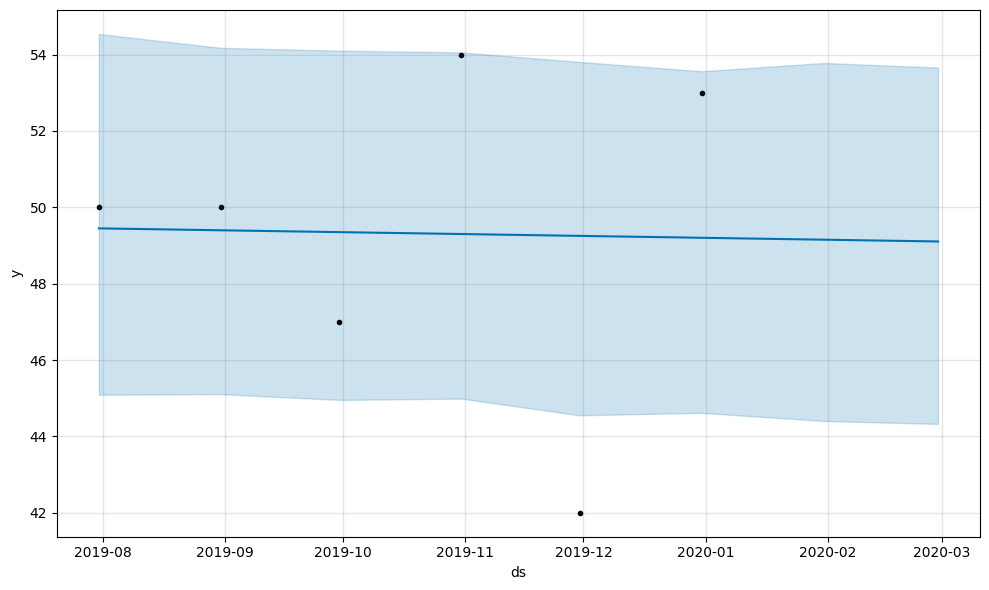

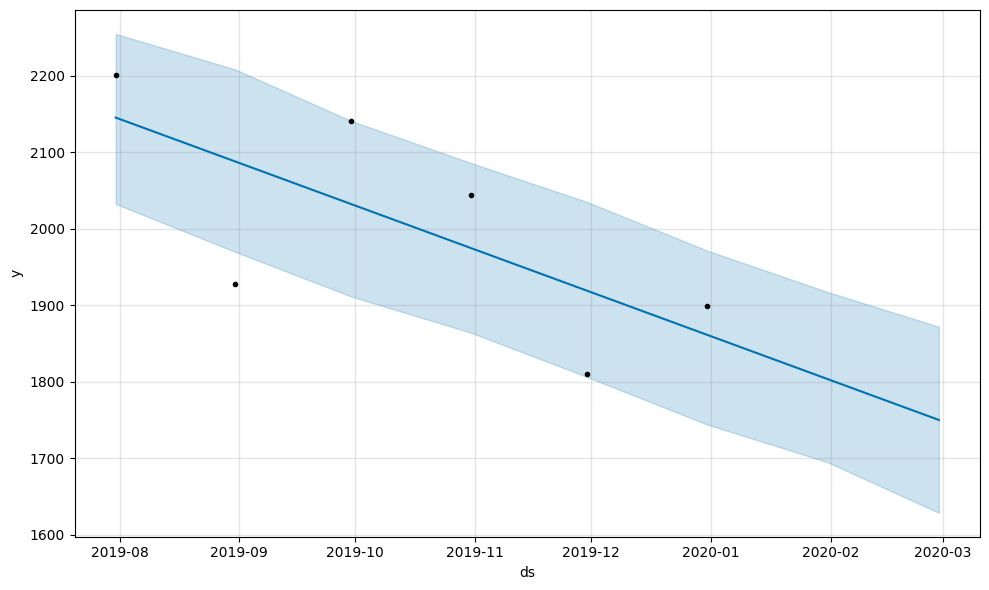

In [8]:
print(f"Total number of models: {len(model)}")
print(f"TOTAL TIME TAKEN: {time_regular_python/60:.2f} minutes")

# Verify you have 1 model and 1 forecast per unique ID.
assert len(model) == len(ID_LIST)
assert len(forecast) == len(ID_LIST)

# plot first two forecasts
plt.figure(figsize=(8, 5))
for p, v in enumerate(ID_LIST[0:2]):
    display(forecast[p].tail(2))
    model[p].plot(forecast[p])

# Ray distributed Python

In [9]:
###########
# Convert existing functions to Ray remote functions
###########

# Convert your regular python functions to ray remote functions
train_model_prophet_remote = ray.remote(train_model_prophet).options(num_returns=3)
inference_model_prophet_remote = ray.remote(inference_model_prophet).options(num_returns=2)

In [10]:
%%capture
# hide noisy output

###########
# Ray distributed program flow to train and inference ARIMA models
###########
model = []
train = []
valid = []
forecast_obj_refs = []

# Train every model.
start = time.time()
train_obj_refs, valid_obj_refs, model_obj_refs = map(
    list,
    zip(
        *(
            [
                train_model_prophet_remote.remote(
                    # g_month,
                    input_data_ref,
                    input_value=v,
                )
                for v in ID_LIST
            ]
        )
    ),
)

# Inference every model.
error_obj_refs, forecast_obj_refs = map(
    list,
    zip(
        *(
            [
                inference_model_prophet_remote.remote(
                    model_obj_refs[p], 
                    train_obj_refs[p],
                    valid_obj_refs[p],
                    input_value=v)
                for p,v in enumerate(ID_LIST)
            ]
        )
    ),
)

# ray.get() means block until all objectIDs requested are available
forecast = ray.get(forecast_obj_refs)
error = ray.get(error_obj_refs)
model = ray.get(model_obj_refs)

# Print some training stats
time_ray_local = time.time() - start
# print(f"Total number of models: {len(model)}")
# print(f"TOTAL TIME TAKEN: {time_ray_local/60:.2f} minutes")

In [14]:
# Print some training stats
print(f"Total number of models: {len(model)}")
print(f"TOTAL TIME TAKEN: {time_ray_local/60:.2f} minutes")

# Calculate speedup:
speedup = time_regular_python / time_ray_local
print(f"Speedup from running Ray parallel code on your laptop: {np.round(speedup, 1)}x"
      f", or {(np.round(speedup, 0)-1) * 100}%")

Total number of models: 260
TOTAL TIME TAKEN: 0.46 minutes
Speedup from running Ray parallel code on your laptop: 4.0x, or 300.0%


### Inspect a few forecasts

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,unique_id
6,2020-01-31,49.151589,44.225701,53.358338,49.151589,49.151589,0.0,0.0,0.0,0.0,0.0,0.0,49.151589,34.0,1
7,2020-02-29,49.104879,44.470122,53.851707,49.104879,49.104879,0.0,0.0,0.0,0.0,0.0,0.0,49.104879,35.0,1


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat,y,unique_id
6,2020-01-31,1803.646884,1687.067391,1916.168737,1803.646883,1803.646885,0.0,0.0,0.0,0.0,0.0,0.0,1803.646884,1689.0,10
7,2020-02-29,1749.834696,1647.298750,1865.302145,1749.834691,1749.834701,0.0,0.0,0.0,0.0,0.0,0.0,1749.834696,1386.0,10


<Figure size 800x500 with 0 Axes>

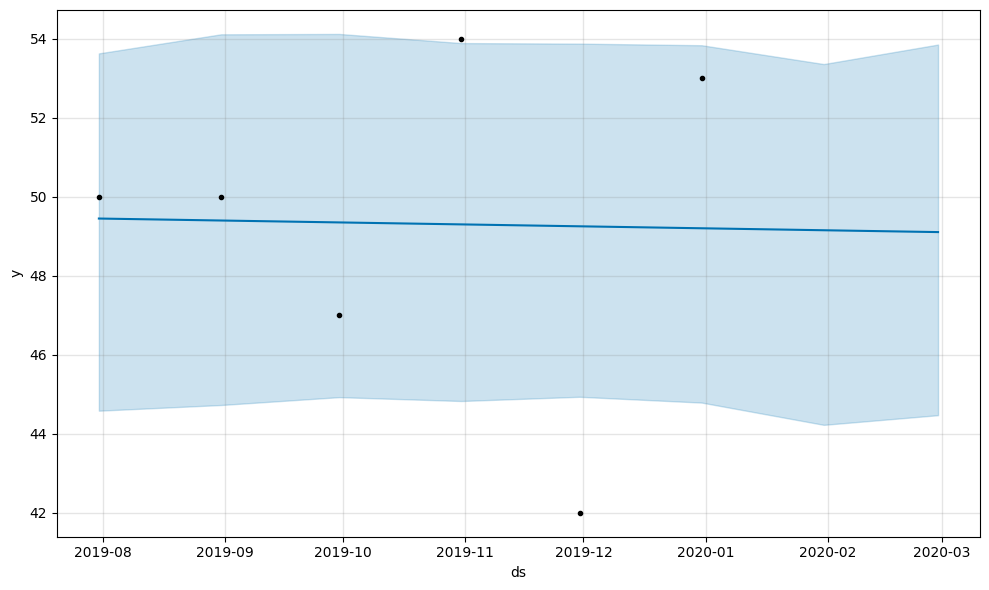

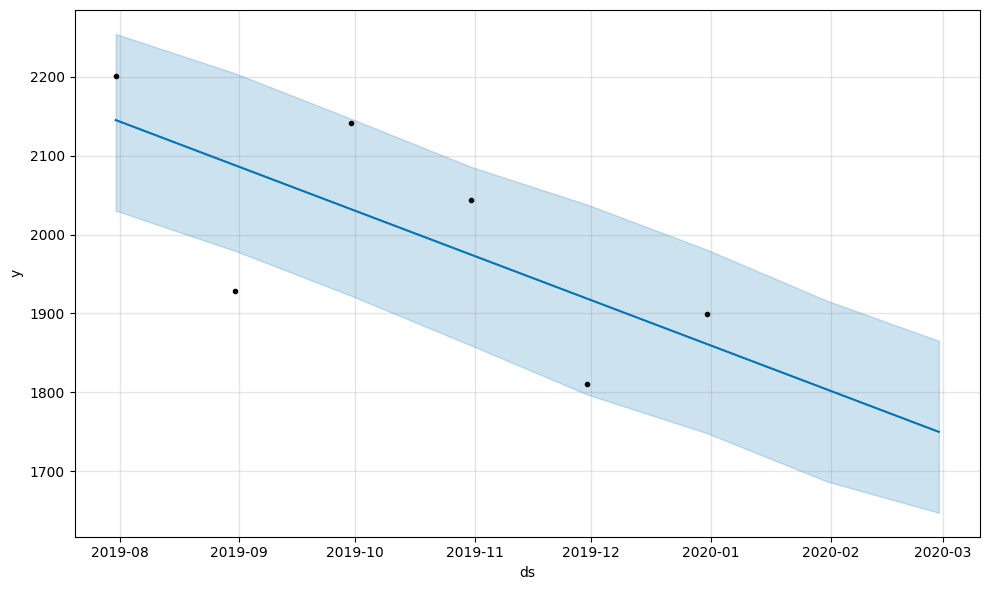

In [12]:
# Verify you have 1 model and 1 forecast per unique ID.
assert len(model) == len(ID_LIST)
assert len(forecast) == len(ID_LIST)

# plot first two forecasts
plt.figure(figsize=(8, 5))
for p, v in enumerate(ID_LIST[0:2]):
    display(forecast[p].tail(2))
    model[p].plot(forecast[p])

In [15]:
import ray

if ray.is_initialized():
    ray.shutdown()